In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [16]:
from scipy.stats import linregress
from statsmodels.stats.multitest import multipletests

In [17]:
PRO_SEQ_NAMES = ['pro_seq_0', 'pro_seq_1']
RNA_SEQ_NAMES = ['rna_seq_0', 'rna_seq_1', 'rna_seq_2', 'rna_seq_3']

In [18]:
gene_fes = pd.read_csv("../data/ref/homo_sapiens/annot/out/fe_stat.csv")
gene_tpm = pd.read_csv("../data/blumberg21/gene_tpm.csv")

In [19]:
gene_tpm['mean_pro_log1p_tpm'] = np.log1p(gene_tpm[PRO_SEQ_NAMES].mean(axis=1))
gene_tpm['mean_rna_log1p_tpm'] = np.log1p(gene_tpm[RNA_SEQ_NAMES].mean(axis=1))

In [20]:
gene_tpm.drop(columns=RNA_SEQ_NAMES + PRO_SEQ_NAMES, inplace=True)

In [21]:
frame = gene_fes.merge(gene_tpm, on='gene')
frame = frame.drop(columns='make_up')

In [22]:
frame

,gene,fe_no,ss_no,tran_no,mean_pro_log1p_tpm,mean_rna_log1p_tpm
0,ENSG00000000003,2,4,4,0.943381,1.379418
1,ENSG00000000005,2,2,2,0.000000,0.996066
2,ENSG00000000419,6,6,16,6.360316,6.479538
3,ENSG00000000457,3,3,5,5.954892,4.946222
4,ENSG00000000460,4,5,9,6.432295,6.334341
...,...,...,...,...,...,...
19067,ENSG00000293563,1,2,3,0.000000,0.000000
19068,ENSG00000293569,1,1,1,3.097440,0.575316
19069,ENSG00000293570,2,2,2,0.000000,0.000000
19070,ENSG00000293584,1,1,1,0.000000,0.000000


In [23]:
# sns.boxplot(frame[frame['tran_num'] == 3], x='fe_no', y='mean_pro_log1p_tpm')

In [24]:
corr_data = []

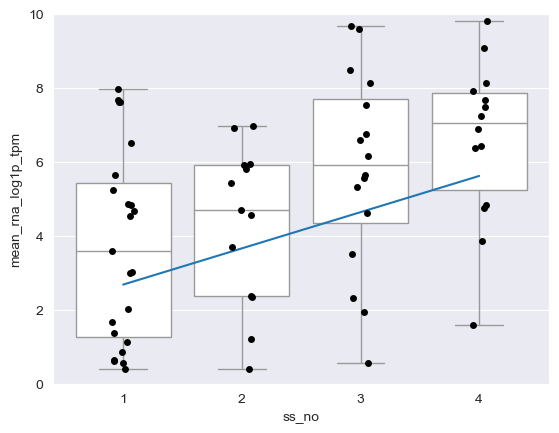

In [25]:
for tran_no in sorted(frame['tran_no'].unique()):
    if tran_no == 1:
        continue
        
    new_frame = frame[frame['tran_no'] == tran_no]
    new_frame = new_frame[new_frame['fe_no'] == 1]
        
    for cat in ['pro', 'rna']:
        new_frame = new_frame[new_frame[f'mean_{cat}_log1p_tpm'] > 0]
        
        X = new_frame['ss_no'].values
        y = new_frame[f'mean_{cat}_log1p_tpm'].values
        
        if len(X) < 20:
            continue
        
        m, b, r, p, *_ = linregress(X, y)
        corr_data.append({
            'm': m, 
            'b': b, 
            'r': r, 
            'p': p, 
            'tran_no': tran_no,
            'cat': cat
        })
        
        if tran_no == 8:
            plt.clf()
            
            new_frame.loc[new_frame['ss_no'] > 4, 'ss_no'] = 4 
            
            g = sns.stripplot(new_frame, x='ss_no', y=f'mean_{cat}_log1p_tpm', color='black')
            _ = sns.boxplot(new_frame, x='ss_no', y=f'mean_{cat}_log1p_tpm', color='white', showfliers=False)

            if len(X) < 20:
                continue
            
            x = np.arange(len(g.get_xticks()))
            plt.plot(x, m*x + b)

            if cat == "pro":
                char = "c"
            else:
                char = "d"

            _ = plt.ylim(0, 10)
            plt.savefig(f"figs/main5{char}.pdf")

In [26]:
corr_frame = pd.DataFrame(corr_data)
corr_frame['FDR'] = multipletests(corr_frame['p'].values, method='fdr_bh')[0]

In [27]:
corr_frame

,m,b,r,p,tran_no,cat,FDR
0,0.230438,3.861489,0.035984,0.326667,2,pro,False
1,0.295166,3.195296,0.039310,0.311076,2,rna,False
2,0.779816,3.397831,0.183033,0.000109,3,pro,True
3,0.606910,3.130751,0.124464,0.013306,3,rna,True
4,0.474017,4.127244,0.162972,0.007974,4,pro,True
5,0.672130,3.458533,0.195835,0.002258,4,rna,True
6,0.412547,4.598893,0.164790,0.034417,5,pro,False
7,0.463417,4.023164,0.159440,0.045388,5,rna,False
8,0.305058,4.462892,0.156140,0.085902,6,pro,False
9,0.323275,3.943021,0.136182,0.138048,6,rna,False


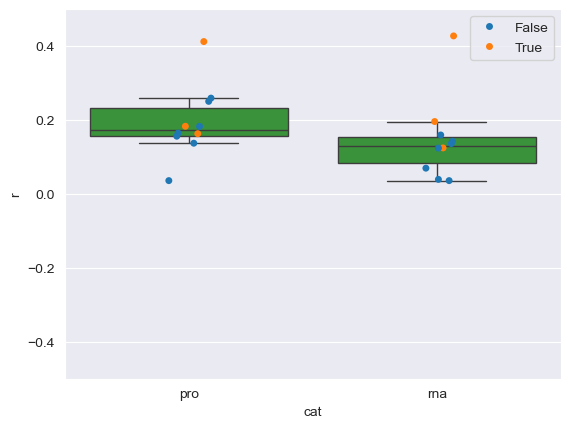

In [28]:
sns.stripplot(corr_frame, x='cat', y='r', hue='FDR')
sns.boxplot(corr_frame, x='cat', y='r', showfliers=False)

plt.ylim(-0.5, 0.5)
plt.savefig("figs/main5b.pdf")